<a href="https://colab.research.google.com/github/BeytullahYayla/Computer-Vision-For-Self-Driving-Cars/blob/main/Classifying%20Road%20Symbols/Classifying_Road_Symbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random 
np.random.seed(0)

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [3]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  valid_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)

In [6]:
print(type(train_data))
X_train,y_train=train_data["features"],train_data["labels"]
X_val,y_val=valid_data["features"],valid_data["labels"]
X_test,y_test=test_data["features"],test_data["labels"]

<class 'dict'>


In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]),"The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]),"The number of images is not equal to the number of labels"
assert(X_train.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:]==(32,32,3)),"The dimensions of the images are not 32x32x3"


In [9]:
data=pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


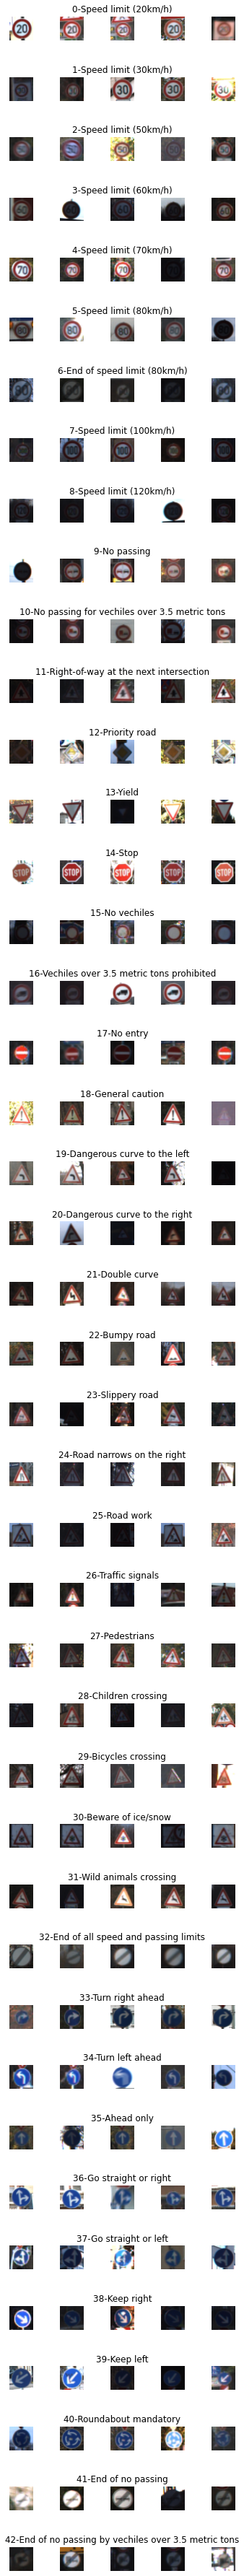

In [10]:
num_of_samples=[]


cols=5
num_classes=43

fig,axs=plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected=X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:],cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j)+"-"+row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


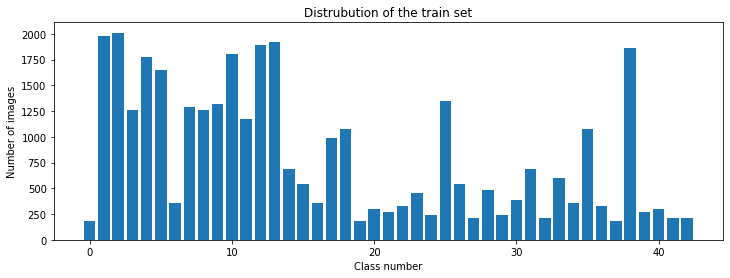

In [11]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distrubution of the train set")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()



In [13]:
import cv2

(32, 32)


(-0.5, 31.5, 31.5, -0.5)

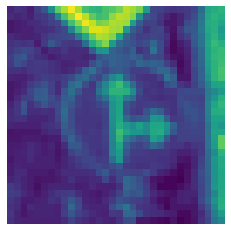

In [14]:
def cvrt_grayscale(img):
  img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  return img

img=cvrt_grayscale(X_train[1000])
print(img.shape)
plt.imshow(img);
plt.axis("off")


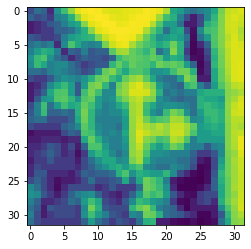

In [15]:
def equalize(img):
  img=cv2.equalizeHist(img)
  return img
img=equalize(img)
plt.imshow(img)

In [16]:
def preprocessing(img):
  grayscale_image=cvrt_grayscale(img)
  equalized_image=equalize(grayscale_image)
  normalized_image=equalized_image/255
  return equalized_image

In [17]:
X_train=np.array(list(map(preprocessing,X_train)))
X_val=np.array(list(map(preprocessing,X_val)))
X_test=np.array(list(map(preprocessing,X_test)))


(34799, 32, 32)


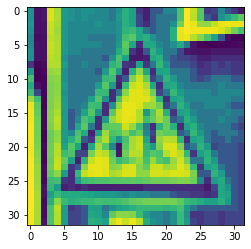

In [18]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
print(X_train.shape)

In [19]:
X_train=X_train.reshape(34799, 32, 32,1)
X_val=X_val.reshape(4410,32,32,1)
X_test=X_test.reshape(12630,32,32,1)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=10,
                           zoom_range=0.2,
                           rotation_range=10
                           )
datagen.fit(X_train,)#We apply augmentation on X_train

Augmented Images


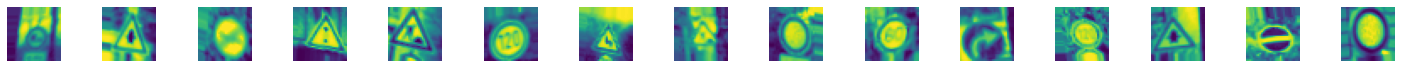

In [21]:
batches=datagen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch=next(batches)
fig,axs,=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

print("Augmented Images")

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis("off")

In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [23]:
y_train=to_categorical(y_train,43)
y_val=to_categorical(y_val,43)
y_test=to_categorical(y_test,43)

## Lenet Implementation

In [24]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [25]:
model = modified_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [31]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=441,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
441/441 [==============================] - 271s 613ms/step - loss: 0.4570 - accuracy: 0.8607 - val_loss: 0.1911 - val_accuracy: 0.9333
Epoch 2/10
441/441 [==============================] - 267s 606ms/step - loss: 0.4119 - accuracy: 0.8741 - val_loss: 0.0917 - val_accuracy: 0.9698
Epoch 3/10
441/441 [==============================] - 264s 600ms/step - loss: 0.3801 - accuracy: 0.8844 - val_loss: 0.1166 - val_accuracy: 0.9603
Epoch 4/10
441/441 [==============================] - 264s 599ms/step - loss: 0.3437 - accuracy: 0.8941 - val_loss: 0.1035 - val_accuracy: 0.9667
Epoch 5/10
441/441 [==============================] - 263s 596ms/step - loss: 0.3354 - accuracy: 0.8979 - val_loss: 0.0866 - val_accuracy: 0.9712
Epoch 6/10
441/441 [==============================] - 265s 601ms/step - loss: 0.2947 - accuracy: 0.9105 - val_loss: 0.0700 - val_accuracy: 0.9785
Epoch 7/10
441/441 [==============================] - 264s 599ms/step - loss: 0.2917 - accuracy: 0.9136 - val_loss: 0.0531 -

Text(0, 0.5, 'Loss')

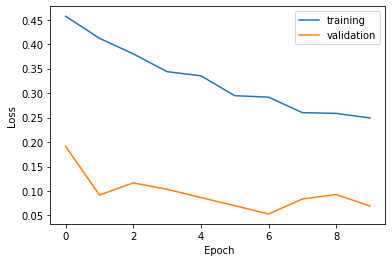

In [39]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['training','validation'])
plt.xlabel(" Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

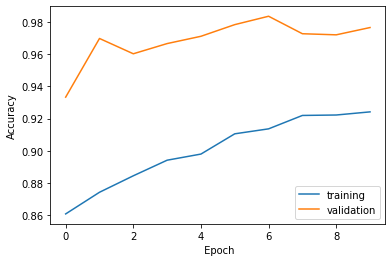

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.legend(['training','validation'])
plt.xlabel(" Epoch")
plt.ylabel("Accuracy")

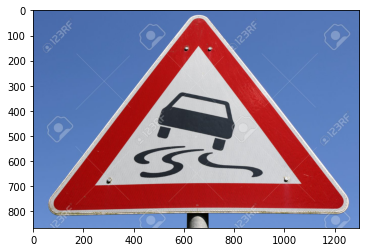

In [34]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


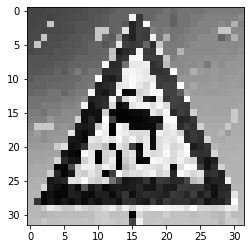

In [35]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [36]:
img = img.reshape(1, 32, 32, 1)

In [37]:
predicted_image=model.predict(img)
predicted_class=np.argmax(predicted_image,axis=1)
print("predicted sign: "+ str(predicted_class))

predicted sign: [23]
